# Testing a Model
---
Once we have a trained model, we can test it. For instance to publish results. Normally we only perform this once on the test-set. If we repeatedly process the test file we run the risk of over-fitting on the test-data set, which is not good.

This notebook will introduce some more metrics to assess the performance of the model on unseen data.

We'll run this process on the test data-set, but it can equally be run on the validation data-set.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt

from typing import Tuple

## The file
We are going to use a similar file to the one in the previous notebook.

In [2]:
header = 'Date,Amount,Card,Merchant,MCC,Country,Fraud\n'
file = './data/bigger_card.csv'

MCC_LIST = [f'{i:04d}' for i in range(25)] # Create 25 MCC-Codes
MCC_PROB = list(np.random.random(len(MCC_LIST)))
MCC_PROB = [p/sum(MCC_PROB) for p in MCC_PROB]

Country_LIST = ['FR', 'DE', 'GB', 'NL', 'ES', 'IT', 'SE', 'PL', 'CH'] # Create 9 country codes
Country_PROB = list(np.random.random(len(Country_LIST)))
Country_PROB = [p/sum(Country_PROB) for p in Country_PROB]

number_of_records = 10000

with open(file, 'w') as f:
    f.write(header)
    for i in range(number_of_records):
        # Dates in range 1st till 30th of January, increasing.
        date = f'202001{int((i/(number_of_records/30))+1):02d}'
        # Random normally distributed amount. Mean 100, stddev 30. Rounded to 2 decimals.
        amount = np.around(np.random.normal(100, 30, 1), 2).item()
        # Create a random card nr 0 to 50
        card_nr = np.random.randint(50)
        # Select an MCC, draw from MCC List accoring to MCC_PROB probability distribution.
        MCC = np.random.choice(MCC_LIST, 1, p=MCC_PROB).item()
        # Select an MCC, draw from Country List accoring to County_PROB probability distribution.
        Country = np.random.choice(Country_LIST, 1, p=Country_PROB).item()
        # Assign some Fraud, this can not be random if we the model to learn something.
        Fraud = 1 if Country in ['FR', 'NL'] and amount > 100 and MCC in ['0001', '0002', '0003', '0010'] else 0
        # Make row and write.
        row = f'{date},{amount},CARD-{card_nr},MRC-{MCC},{MCC},{Country},{Fraud}\n'
        f.write(row)

## Create our features and data-loader

In [3]:
amount  = ft.FeatureSource('Amount', ft.FEATURE_TYPE_FLOAT_32)
mcc     = ft.FeatureSource('MCC', ft.FEATURE_TYPE_CATEGORICAL, default='0000')
country = ft.FeatureSource('Country', ft.FEATURE_TYPE_CATEGORICAL)
fraud   = ft.FeatureSource('Fraud', ft.FEATURE_TYPE_INT_8)

amount_scaled = ft.FeatureNormalizeScale('Scaled_Amount', ft.FEATURE_TYPE_FLOAT_32, amount)
mcc_oh        = ft.FeatureOneHot('MCC_OH', ft.FEATURE_TYPE_INT_8,  mcc)
country_oh    = ft.FeatureOneHot('Country_OH', ft.FEATURE_TYPE_INT_8, country)
fraud_label   = ft.FeatureLabelBinary('Fraud_Label', ft.FEATURE_TYPE_INT_8, fraud)

td_oh     = ft.TensorDefinition('Features_OH', [mcc_oh, country_oh])
td_amount = ft.TensorDefinition('Feature_Amount', [amount_scaled])
td_label  = ft.TensorDefinition('Feature_Fraud', [fraud_label])


with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_oh, td_amount, td_label), file, inference=False)
    
train, val, test = ti.split_sequential(2000,1000)

train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

cpu        = torch.device('cpu')
batch_size = 32

train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(cpu, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(cpu, batch_size, num_workers=2)

2023-04-18 22:24:08.367 eng1n3.common.engine           INFO     Start Engine...
2023-04-18 22:24:08.367 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-04-18 22:24:08.367 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-04-18 22:24:08.368 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ./data/bigger_card.csv
2023-04-18 22:24:08.378 e...renormalizescaleprocessor  INFO     Create Scaled_Amount Scale Amount. Min. -14.75 Max. 211.09
2023-04-18 22:24:08.379 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-04-18 22:24:08.380 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays


## Model

Create our model again, it should be fairly similar by now.

In [4]:
class FirstModel(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(FirstModel, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads()
        
        # One Linear Layer that maps the output of the heads, size 11 to size 1.
        self.l1 = nn.Linear(in_features=sum([h.output_size for h in self.heads]), out_features=1)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail()

    # Create a forward-pass function through the neural net. Make sure to return a LIST of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.l1(o)
        o = self.tail(o)
        return (o,)

#Create a 'FirstModel' instance
model = FirstModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

FirstModel(
  Number of parameters : 36. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(Name=Features_OH, lc=Binary)
    (1): TensorDefinitionHead(Name=Feature_Amount, lc=Continuous)
  )
  (l1): Linear(in_features=35, out_features=1, bias=True)
  (tail): Sigmoid()
)

## Train our model again
Train the model and plot the training history.

In [5]:
# First create a trainer.
trainer = mp.Trainer(model, torch.device('cpu'), train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=0.1)
# Run the trainer for 5 epochs
history = trainer.train(5, optimizer)

Epoch 005/005: 100%|██████████| 282/282 [00:00<00:00, 1184.83it/s, t_loss=0.0397, t_acc=0.99, v_loss=0.0701, v_acc=0.976]      


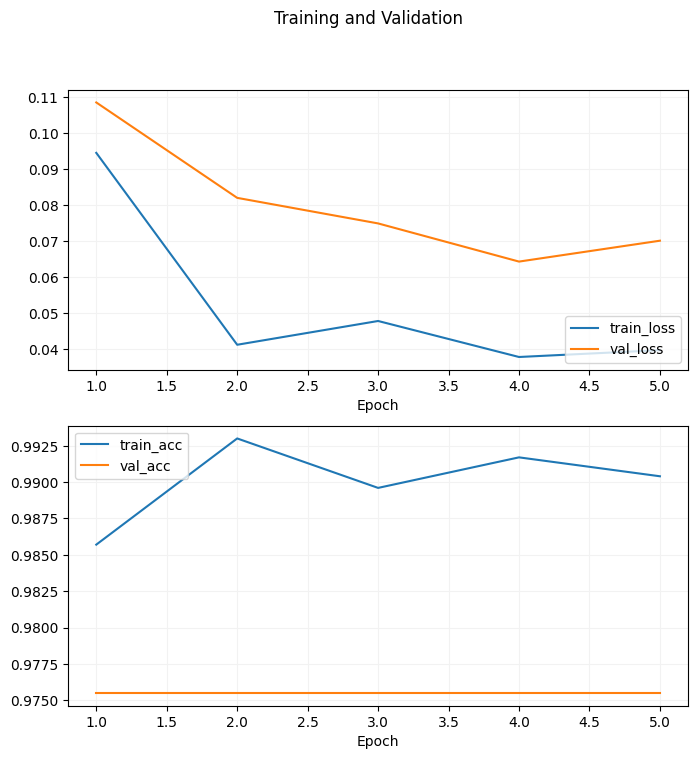

In [6]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

## Test the Model

In [7]:
t = mp.Tester(model, torch.device('cpu'), test_dl)
results = t.test_results_binary()

Testing in 32 steps: 100%|█████████████████████| 32/32 [00:00<00:00, 600.39it/s]


In [8]:
mplt.TestPlot.print_binary_classification_report(results)

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       986
         1.0       0.48      1.00      0.65        14

    accuracy                           0.98      1000
   macro avg       0.74      0.99      0.82      1000
weighted avg       0.99      0.98      0.99      1000


auc score : 0.9980
ap score  : 0.7951
-----------------------------------------------------


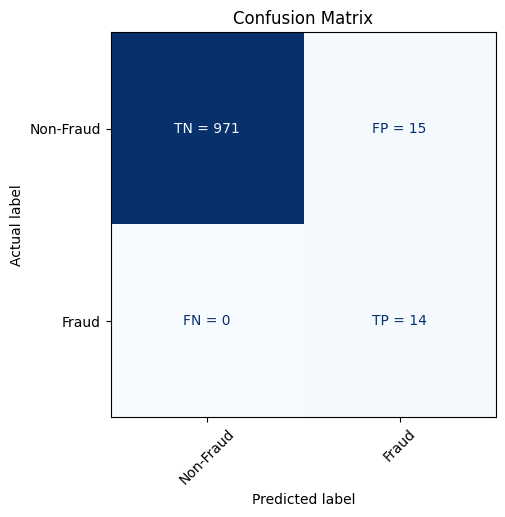

In [9]:
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5))

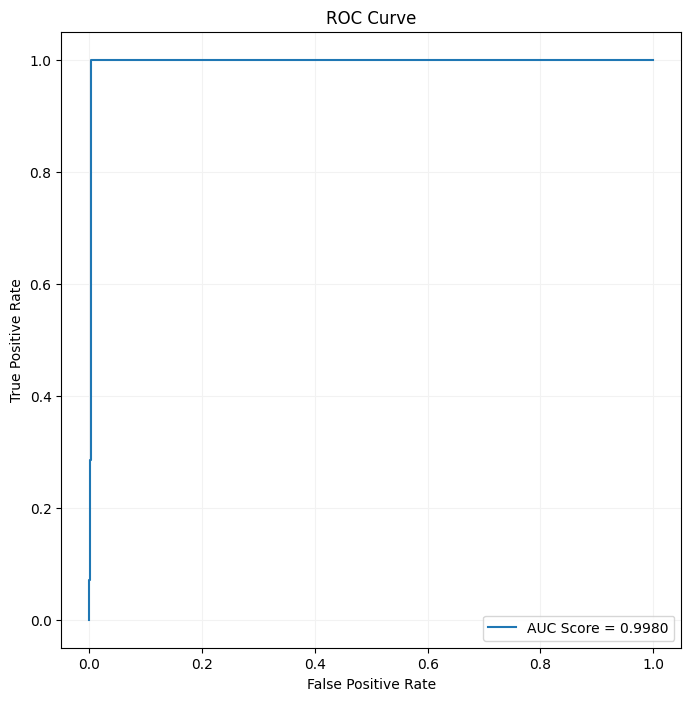

In [10]:
mplt.TestPlot.plot_roc_curve(results, fig_size=(8,8))

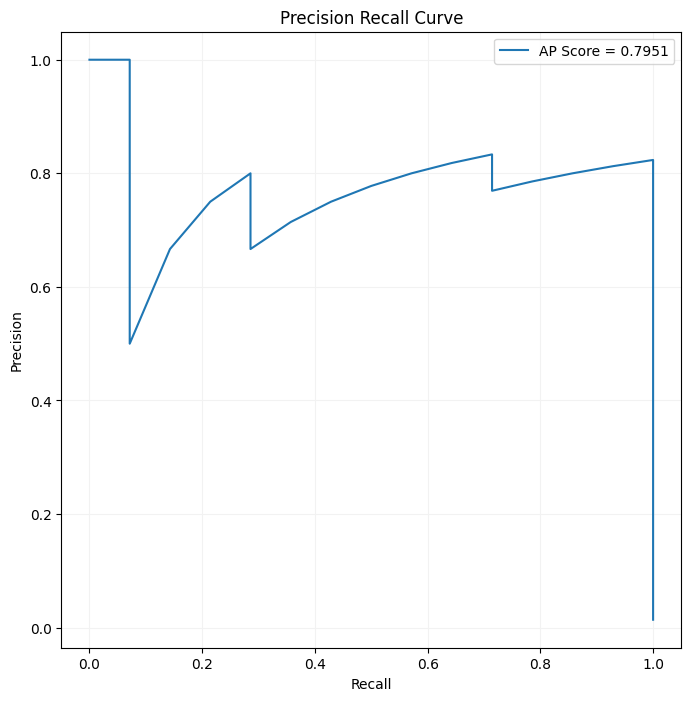

In [11]:
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(8,8))

Clean-up after ourselves. Delete our test file.

In [12]:
!rm $file

## Conclusion
In this notebook we saw how to test a model on a test file, this is the file you would normally use to report results. We can see that our very simple model does home in on the fraud label. But this is a simple example obviously.